# Indices Mosaic Notebook

Notebook to allow generation of mosaics using Indices - Indicies include Normalise Difference Vegetation Index (NDVI), Enhanced Vegetation Index (EVI) and Normalised Difference Water Index (NDWI). 


In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
# Generic python
import matplotlib.pyplot as plt
import xarray as xr 
from shapely import wkt
from datetime import datetime
import datacube
from matplotlib.cm import RdYlGn, Greens, Blues

In [2]:
#import datacube utilities
import datacube_utilities.data_access_api as dc_api  
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic, create_mean_mosaic, create_min_ndvi_mosaic
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.dc_water_quality import tsm
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.createindices import NDVI, NDWI, EVI
from datacube_utilities.clean_mask import landsat_qa_clean_mask

In [3]:
api = dc_api.DataAccessApi()
dc = datacube.Datacube(app='indices mosaic')

## Set variables

In [4]:
#area of interest: load in as wkt
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"

In [5]:
#Set- projection: This is the same for all of FIJI so this may not need to be a variable within the Fijian cube.
output_projection = "EPSG:32760"

In [6]:
#set resolution_ if using Landsat min 30, if sentinel min 10
res = 30

In [7]:
#platform is the sensor, options include 'LANSAT_8', 'LANSAT_7', 'LANSAT_5', 'LANSAT_4', 'SENTINEL_2'
platform = 'LANDSAT_4'

In [8]:
#select a single time range for query
time_start = ('1990-1-1')
time_end = ('1995-2-1')

In [9]:
# Select the cloud-free mosaic type
# Options are: max, median, most_recent_pixel, min, mean
mosaic_type = "max"

In [10]:
#indices type
#Options include evi, ndvi, ndwi
indices = EVI

## Create AOI

In [11]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [12]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

## Translate inputs and load data

In [13]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
if platform  in ["SENTINEL_2"]:
    product = 's2_esa_sr_granule'
    measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
elif platform in ["LANDSAT_8"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls8_usgs_sr_scene'
elif platform in ["LANDSAT_7"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls7_usgs_sr_scene'
elif platform in ["LANDSAT_5"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls5_usgs_sr_scene'
elif platform in ["LANDSAT_4"]:    
    measurements = allmeasurements + ["pixel_qa"]
    product = 'ls4_usgs_sr_scene'
else:
    print("invalid platform")

In [14]:
#create resolution
resolution = (-res, res)

In [15]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_extents,
    'x': lon_extents,
    'output_crs': output_projection,  
    'resolution': resolution,
    'product' : product,
    'platform' : platform, 
    'measurements' : measurements
}

In [16]:
#format dates
def createDate(inputDate):
    outputDate = datetime.strptime(inputDate, '%Y-%m-%d')
    outputDates = outputDate.date()
    return outputDates

dateStart = createDate(time_start)
dateEnd = createDate(time_end)
time_range = (dateStart, dateEnd)

In [17]:
loaded_ds = dc.load(
    time = time_range,
    **query
)

### Check if loads are valid

In [18]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [19]:
if is_dataset_empty(loaded_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

## Create cloud mask

In [20]:
#create cloud mask
clean_mask = landsat_qa_clean_mask(loaded_ds, platform)

In [21]:
loaded_ds = loaded_ds.where(clean_mask)

## Perform Mosaic

In [22]:
mosaic_function = {"median": create_median_mosaic,
                   "max": create_max_ndvi_mosaic,
                   "most_recent_pixel": create_mosaic,
                   "mean": create_mean_mosaic,
                   "min": create_min_ndvi_mosaic
                  }

In [23]:
mosaic_compositor = mosaic_function[mosaic_type]

In [24]:
mosaiced_composite = mosaic_compositor(loaded_ds, clean_mask = clean_mask)

## Calculate Indices and Plot

In [25]:
indices_composite = indices(mosaiced_composite)

In [26]:
print(indices_composite)

<xarray.DataArray (y: 261, x: 213)>
array([[-0.42916957, -0.27979982, -0.11898017, ..., -0.10140406,
        -0.01729249, -0.10140406],
       [-0.22186365, -0.22186365, -0.11554146, ..., -0.12023677,
        -0.14051016, -0.20994832],
       [-0.17683773, -0.17473608, -0.13919214, ..., -0.14051016,
        -0.14051016, -0.14051016],
       ...,
       [-0.20582647, -0.20582647, -0.23428233, ...,  0.01883746,
         0.01704822, -0.0131268 ],
       [-0.20582647, -0.13865188, -0.19026975, ..., -0.01248751,
        -0.0222662 ,  0.01624695],
       [-0.13865188, -0.13865188, -0.11887345, ..., -0.01043515,
        -0.01087784,  0.01624695]])
Coordinates:
  * y            (y) float64 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x            (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05
    spatial_ref  int32 32760


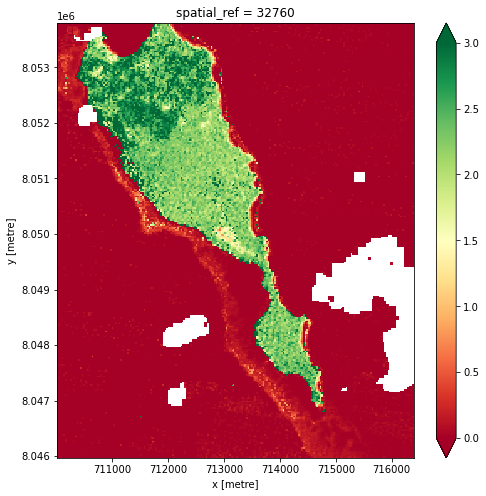

In [27]:
plt.figure(figsize = (8,8))
if indices in [NDVI]:
    indices_composite.plot(vmin=0, vmax=1, cmap = RdYlGn)
elif indices in [NDWI]:
    indices_composite.plot(vmin=-1, vmax=1, cmap = Blues)
elif indices in [EVI]:
    indices_composite.plot(vmin=0, vmax=3, cmap = RdYlGn)
else:
    print('indicies invalid')


In [28]:
indices_composite_output = xr.DataArray.to_dataset(indices_composite, dim = None, name = 'ndvi')

In [29]:
write_geotiff_from_xr('indices_composite.tiff', indices_composite_output, ["ndvi"], crs=output_projection, x_coord = 'x', y_coord = 'y')

---